In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utility.models import *
from utility.data_loader import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
import json

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
data_path = "/content/gdrive/My Drive/HDMI_Data/Data_image/"    
save_model_path = "/content/gdrive/My Drive/HDMI_Data/Model/"
test_video_path = "/content/gdrive/My Drive/HDMI_Data/testVideo_image/testSample3"

In [0]:
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512   
res_size = 224        
dropout_p = 0.3       

RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 256

k = 2           
epochs = 40        
batch_size = 40  
learning_rate = 1e-3
log_interval = 10   

begin_frame, end_frame, skip_frame = 1, 8, 1

In [14]:
action_names = []
action_names.append('Not Walking')
action_names.append('Walking')
use_cuda = torch.cuda.is_available()                   
device = torch.device("cuda" if use_cuda else "cpu")   
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
le = LabelEncoder()
le.fit(action_names)
list(le.classes_)
action_category = le.transform(action_names).reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(action_category)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [0]:
testActions = []
fnames = os.listdir(test_video_path)
all_names = []
for f in fnames:
    all_names.append(f)
    if 'walk' in f:
        testActions.append("Walking")
    else:
        testActions.append("Not Walking")           

In [0]:
all_X_list = all_names             
all_y_list = labels2cat(le, testActions)    
use_cuda = torch.cuda.is_available()                   
device = torch.device("cuda" if use_cuda else "cpu") 
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

In [0]:
all_data_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
all_data_loader = data.DataLoader(Dataset_CRNN(test_video_path, all_X_list, all_y_list, selected_frames, transform=transform), **all_data_params)

In [19]:
cnn_encoder = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)

cnn_encoder.load_state_dict(torch.load(os.path.join(save_model_path, 'cnn_encoder_epoch25.pth')))
rnn_decoder.load_state_dict(torch.load(os.path.join(save_model_path, 'rnn_decoder_epoch25.pth')))
print('CRNN model reloaded!')

CRNN model reloaded!


In [29]:
print('Predicting all {} videos:'.format(len(all_data_loader.dataset)))
all_y_pred = CRNN_final_prediction([cnn_encoder, rnn_decoder], device, all_data_loader)


  0%|          | 0/1 [00:00<?, ?it/s]

Predicting all 8 videos:



100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


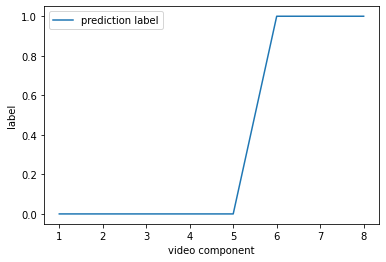

In [30]:
x = []
for i in range(len(all_y_pred)):
  x.append(i+1)
plt.plot(x, pred) 
plt.xlabel('video component')
plt.ylabel('label')
plt.legend(['prediction label'], loc="upper left")
plt.savefig('/prediction', dpi=600)

In [0]:
def get_json(prediction):
  res = {}
  for i in range(len(prediction)):
    res[i] = prediction[i]
  result = {}
  result['walk'] = res
  with open('result.json', 'w') as json_file:
    json.dump(result, json_file)